In [1]:
import pylab as pl
import pandas as pd
import numpy as np
from scipy import stats
import os
import json

%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Idea


#### Men are more likely to ride at night than women. 


# Hypotheses

## Null:  

    The average difference between male and female ridership during the last 4 hours of the day and first 4 hours of the day is the larger than the average difference at all other times.  

    Let M be Male and F be Female
    
_$H_0$ : $\frac{M{\mathrm{nighttime}} - F{\mathrm{nighttime}}}{M{\mathrm{nighttime}} + F{\mathrm{nighttime}}} -  \frac{M{\mathrm{daytime}} - F{\mathrm{daytime}}}{M{\mathrm{daytime}} + F{\mathrm{daytime}}} > 0 $

_$H_1$ : $\frac{M{\mathrm{nighttime}} - F{\mathrm{nighttime}}}{M{\mathrm{nighttime}} + F{\mathrm{nighttime}}} -  \frac{M{\mathrm{daytime}} - F{\mathrm{daytime}}}{M{\mathrm{daytime}} + F{\mathrm{daytime}}} <= 0 $

In [2]:
# Download data and move to PUIDATA...
#  The following function will create the necessary commands
#   to download the data from CitiBike's website and load them
#   into multiple csv's.

def CitiBikedata(date):
    #create url to download data
    url = "https://s3.amazonaws.com/tripdata/" + date + "-citibike-tripdata.csv.zip"
    os.system("curl -O " + url)
    os.system("unzip " + date + "-citibike-tripdata.csv.zip")
    os.system("mv " + date + "-citibike-tripdata.csv $PUIDATA")
    os.system("rm " + date + "-citibike-tripdata.csv.zip")

In [3]:
#Download a 5 month range of data from April 2017 to August 2017. This for loop will load each csv into a dataframe
#  and add it to a list called frames. In the next cell, all these dataframes are concatenated into one dataframe to 
#  be used for the analysis. 

date_call_int = 201703
frames = []
for i in range(5):
    date_call_int = date_call_int + 1
    date_call = str(date_call_int)
    print("Loading data from " + date_call)
    CitiBikedata(date_call)
    df = pd.read_csv(os.getenv("PUIDATA") + "/" + date_call + '-citibike-tripdata.csv')
    frames.append(df)


Loading data from 201704
Loading data from 201705
Loading data from 201706
Loading data from 201707
Loading data from 201708


In [4]:
df_2017_summer = pd.concat(frames)
df_2017_summer.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,195,2017-04-01 00:00:58,2017-04-01 00:04:14,217,Old Fulton St,40.702772,-73.993836,430,York St & Jay St,40.701485,-73.986569,25454,Subscriber,1966.0,1
1,585,2017-04-01 00:01:54,2017-04-01 00:11:40,490,8 Ave & W 33 St,40.751551,-73.993934,3158,W 63 St & Broadway,40.771639,-73.982614,25930,Subscriber,1995.0,1
2,665,2017-04-01 00:01:56,2017-04-01 00:13:01,504,1 Ave & E 16 St,40.732219,-73.981656,412,Forsyth St & Canal St,40.715816,-73.994224,27110,Subscriber,1987.0,1
3,262,2017-04-01 00:02:24,2017-04-01 00:06:47,445,E 10 St & Avenue A,40.727408,-73.981420,411,E 6 St & Avenue D,40.722281,-73.976687,28392,Subscriber,1961.0,1
4,134,2017-04-01 00:02:36,2017-04-01 00:04:50,3423,West Drive & Prospect Park West,40.661063,-73.979453,3300,Prospect Park West & 8 St,40.665147,-73.976376,19316,Subscriber,1967.0,2


In [5]:
#Drop columns I do not need
df_2017_summer_curated = df_2017_summer[['starttime', 'gender']]
df_2017_summer_curated['hour'] = pd.to_datetime(df_2017_summer_curated['starttime'])
df_2017_summer_curated['hour'] = df_2017_summer_curated['hour'].dt.hour
df_2017_summer_curated = df_2017_summer_curated[['gender', 'hour']]
df_2017_summer_curated.head()


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,gender,hour
0,1,0
1,1,0
2,1,0
3,1,0
4,2,0


In [6]:
#We want to create two types of plots here to show the different trends for male and female riders.
#Male df - 1 is male. 2 is female
male_df = df_2017_summer_curated.loc[df_2017_summer_curated['gender'] == 1]
female_df = df_2017_summer_curated.loc[df_2017_summer_curated['gender'] == 2]

#When calculating the total female riders we have to divide by 2, since in Female indicator in our data is 2. 
# If we were to take a direct sum without dividing by 2 we would be caluclating double the female riders than
# there actually are.
male_df_sum = male_df.groupby('hour').sum()
female_df_sum = female_df.groupby('hour').sum() / 2

Text(0,0.5,'Number of Riders')

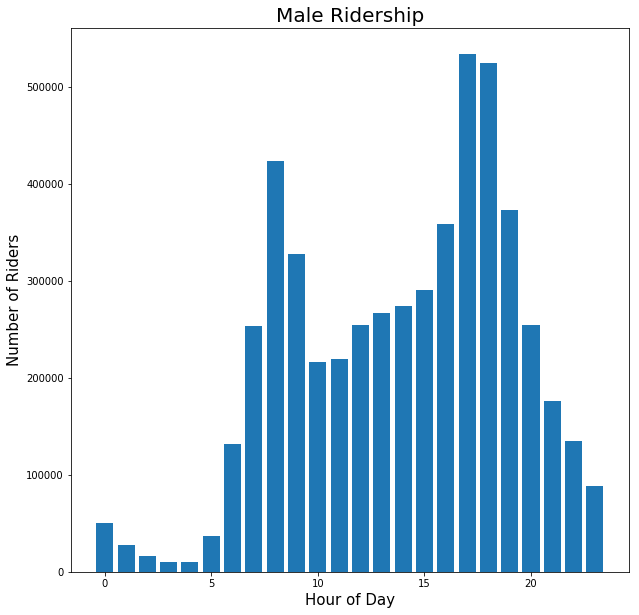

In [7]:
#Overall male ridership based on hour of day

pl.figure(figsize=(10,10))
pl.bar(male_df_sum.index, male_df_sum['gender'])
pl.title("Male Ridership", fontsize = 20)
pl.xlabel("Hour of Day", fontsize = 15)
pl.ylabel("Number of Riders", fontsize = 15)

## Male Ridership

From this bar chart, we can see that male ridership peaks during morning and evening rush hours, as well as a slight increase at during lunchtime. 

Text(0,0.5,'Number of Riders')

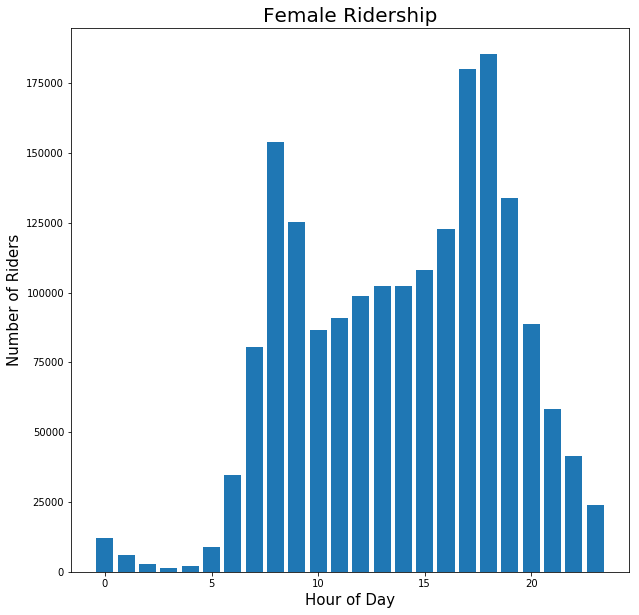

In [8]:
#Overall female ridership based on hour of day

pl.figure(figsize=(10,10))
pl.bar(female_df_sum.index, female_df_sum['gender'])
#pl.hist(female_df['hour'], bins = 24, ec = 'black')
pl.title("Female Ridership", fontsize = 20)
pl.xlabel("Hour of Day", fontsize = 15)
pl.ylabel("Number of Riders", fontsize = 15)

## Female Ridership

From this bar chart, we can see that female ridership peaks during morning and evening rush hours, as well as a slight increase at during lunchtime. Female ridership is also very low during the early hours of the day. 

Based on raw numbers, female ridership is substantially lower than male ridership. (A peak of 175,000 versus 500,000)

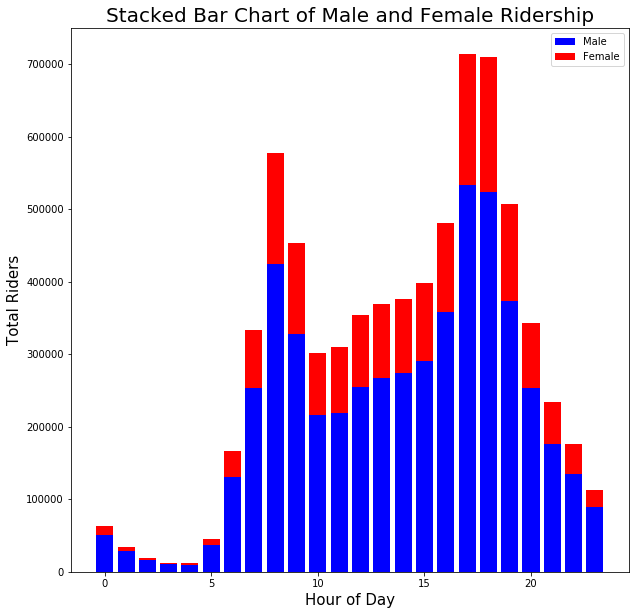

In [9]:
#Plot a stacked bar chart to visualize raw difference between male and female ridership.

pl.figure(figsize = (10,10))
pl.title("Stacked Bar Chart of Male and Female Ridership", fontsize = 20)
pl.ylabel("Total Riders", fontsize = 15)
pl.xlabel("Hour of Day", fontsize = 15)
p_1 = pl.bar(male_df_sum.index, male_df_sum['gender'], color = 'blue')
p_2 = pl.bar(female_df_sum.index, female_df_sum['gender'], bottom = male_df_sum['gender'], color = 'red')
pl.legend((p_1[0], p_2[0]), ('Male', 'Female'))
pl.show()


## Stacked Bar Chart 

This chart mirrors the above two in it's overall shape. However, looking at the nighttime hours we can see that the proportion of women riders to the total is significantly smaller than during the rest of the day. 

Text(0,0.5,'Normalized Difference')

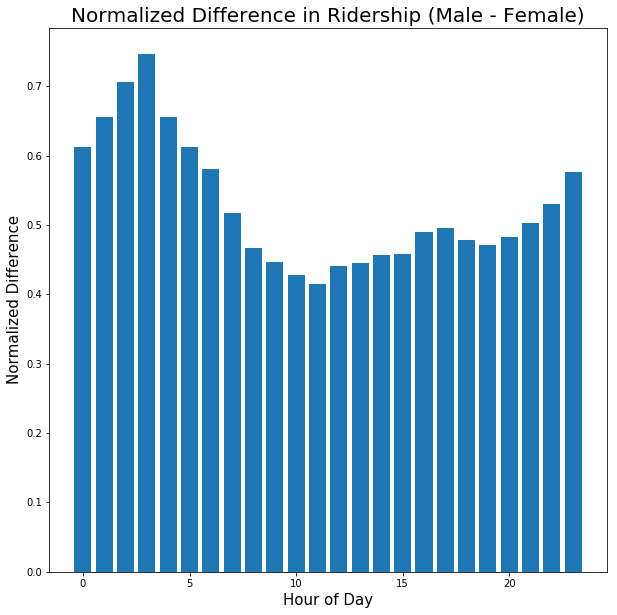

In [10]:
#Calculate male/female ridership at nighttime versus daytime. 
# And use Null hypothesis equations to plot some normalized data. 
# Plot normalized differences between male and female riders..

#Normalize differences between male/female ridership and then plot bar chart
difference = male_df_sum - female_df_sum
total = male_df_sum + female_df_sum
normalized = difference/total



pl.figure(figsize=(10,10))
pl.bar(normalized.index, normalized['gender'])
pl.title("Normalized Difference in Ridership (Male - Female)", fontsize = 20)
pl.xlabel("Hour of Day", fontsize = 15)
pl.ylabel("Normalized Difference", fontsize = 15)


# Figure

The normalized difference calculated above was done in the following manner: $\frac{M{\mathrm{x_{hour}}} - F{\mathrm{x_{hour}}}}{M{\mathrm{x_{hour}}} + F{\mathrm{x_{hour}}}}$

By normalizing in such a manner, we are able to calculate the difference between male/female ridership without having to worry about the raw numbers and focus purely on difference per hour.


In [11]:
male_df_sum = male_df_sum.reset_index()
female_df_sum = female_df_sum.reset_index()

In [12]:
#split by day and night. Then normalize. Then perform two t-tests. 
normalized_male = male_df_sum['gender'] / male_df_sum['gender'].sum()
normalized_female = female_df_sum['gender'] / female_df_sum['gender'].sum()
normalized_male = normalized_male.reset_index()
normalized_female = normalized_female.reset_index()

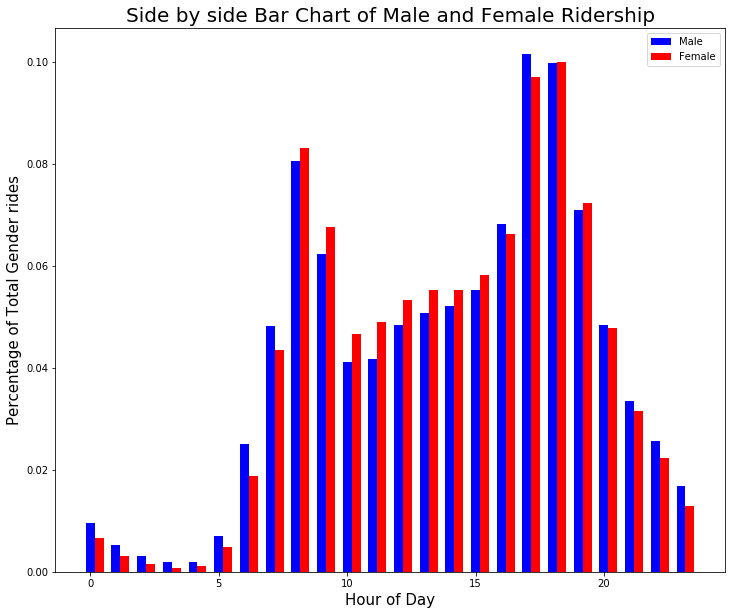

In [13]:
#Plot the normalized values in a bar chart side by side to show trends
width = 0.35
pl.figure(figsize = (12,10))
pl.title("Side by side Bar Chart of Male and Female Ridership", fontsize = 20)
pl.ylabel("Percentage of Total Gender rides", fontsize = 15)
pl.xlabel("Hour of Day", fontsize = 15)
p_1 = pl.bar(normalized_male.index, normalized_male['gender'], width, color = 'blue')
p_2 = pl.bar(normalized_female.index+width, normalized_female['gender'], width, color = 'red')
pl.legend((p_1[0], p_2[0]), ('Male', 'Female'))
pl.show()


## Figure 

In the above figure, we have a standardized view of male and female ridership through the day. As we can see, during nighttime hours, men consistently have higher riding percentages versus the daytime.

In [14]:
day_male = normalized_male.loc[(normalized_male['index'] > 5) & (normalized_male['index'] < 19)]
night_male = normalized_male.loc[(normalized_male['index'] < 5) | (normalized_male['index'] > 19)]

day_female = normalized_female.loc[(normalized_female['index'] > 5) & (normalized_female['index'] < 19)]
night_female = normalized_female.loc[(normalized_female['index'] < 5) | (normalized_female['index'] > 19)]


In [15]:
#use scipy.stats.ttest_rel
print("Day time Paired t test: " + str(stats.ttest_rel(day_male.gender, day_female.gender)))

print("Night time Paired t test: " + str(stats.ttest_rel(night_male.gender, night_female.gender)))

# See if there is a difference between the two distributions. 

Day time Paired t test: Ttest_relResult(statistic=-1.2069815006982507, pvalue=0.25069353387180265)
Night time Paired t test: Ttest_relResult(statistic=5.079431917361628, pvalue=0.00095380088565485824)
